# Run the simulation notebook for one set of parameters


In [129]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from gammapy.datasets import Datasets
from gammapy.estimators import ExcessMapEstimator
from simulation_extended import *
from regions import CircleSkyRegion
from gammapy.makers import FoVBackgroundMaker

In [130]:
simulator = Simulation()
corr_rad = 0.1*u.deg
estimator = ExcessMapEstimator(correlation_radius=corr_rad,
                             selection_optional=None)

The number of simulated obs is 4*n_obs, ie, n_obs is the number of runs simulated at each wobble position. For now, it is the same.
Can make it a list if really necessary

In [131]:
%%time
sigma = 2.0*u.deg
A0 = 5e-11
n_obs = 5
datasets = simulator.run(n_obs=n_obs, sigma=sigma, A0=A0)

Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0.7, 0.)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (359.3, 0.)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0., 0.7)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0., -0.7)>
CPU times: user 31.3 s, sys: 6.5 s, total: 37.8 s
Wall time: 38.2 s


(array([1., 2., 3., 3., 1., 0., 3., 1., 3., 3.]),
 array([0.79600921, 0.83795909, 0.87990898, 0.92185886, 0.96380874,
        1.00575863, 1.04770851, 1.08965839, 1.13160827, 1.17355816,
        1.21550804]),
 <BarContainer object of 10 artists>)

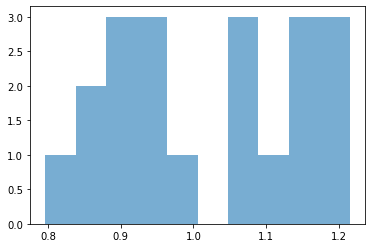

In [132]:
# The injected background systematics are stored in bkg_norms
plt.hist(simulator.bkg_norms, alpha=0.6)

In [133]:
# Stack the datasets for visualisation
stacked = datasets.stack_reduce()

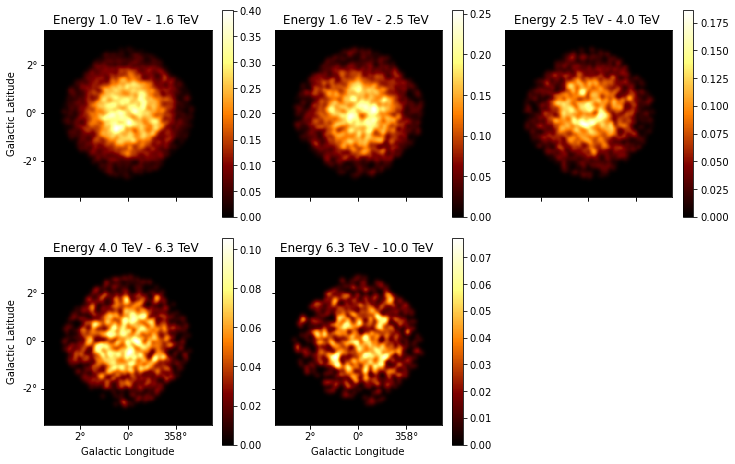

In [134]:
stacked.counts.smooth(0.1*u.deg).plot_grid(add_cbar=True);

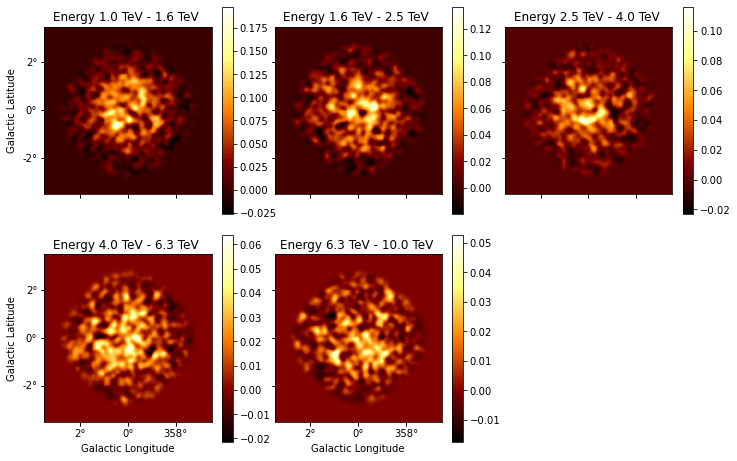

In [135]:
(stacked.counts - stacked.background).smooth(0.1*u.deg).plot_grid(add_cbar=True);

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x176a63c50>)

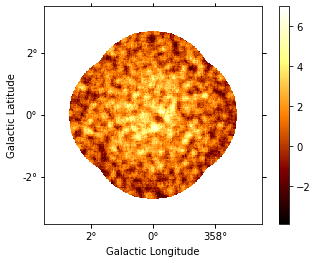

In [136]:
residual1 = estimator.run(stacked)
residual1['sqrt_ts'].plot(add_cbar=True)

In [137]:
#The injected model parameters
model = simulator.sky_model(sigma.value, A0)
model.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str8,float64,float64,bool,int64
amplitude,2.0000e-10,cm-2 s-1,nan,nan,False,0.000e+00
index,2.3000e+00,,nan,nan,False,0.000e+00
emin,1.0000e+00,TeV,nan,nan,True,0.000e+00
emax,1.0000e+01,TeV,nan,nan,True,0.000e+00
lon_0,0.0000e+00,deg,nan,nan,False,0.000e+00
lat_0,0.0000e+00,deg,-9.000e+01,9.000e+01,False,0.000e+00
sigma,2.0000e+00,deg,0.000e+00,nan,False,0.000e+00
e,0.0000e+00,,0.000e+00,1.000e+00,True,0.000e+00
phi,0.0000e+00,deg,nan,nan,True,0.000e+00


In [138]:
minor_axis = model.spatial_model.sigma.quantity * np.sqrt(1 - model.spatial_model.e.value ** 2)

surface_brightness = model.spectral_model.amplitude.quantity/(4*np.pi*minor_axis*model.spatial_model.sigma.quantity)
print(surface_brightness.to(1/(u.cm**2 * u.s * u.sr)))

1.3061871445445794e-08 1 / (cm2 s sr)


In [139]:
## flux in FoV
geom = stacked.counts._geom
np.sum(model.spatial_model.evaluate_geom(geom)*geom.solid_angle())
flux = model.spatial_model.evaluate_geom(geom)*geom.solid_angle()
flux[stacked.exposure.data == 0.0] = 0.0
correction = np.sum(flux)/geom.axes['energy'].nbin
flux_fov_injected = correction * model.spectral_model.amplitude.quantity
print(flux_fov_injected)

1.1449376219334543e-10 1 / (cm2 s)


17597.0 12986.723018967652 0.3549992537993492


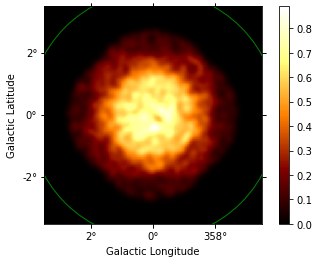

In [140]:
#Source strength as a fraction of background
region = CircleSkyRegion(center=simulator.skydir,
                        radius=2.0*sigma)
bkg_strength = stacked.background.get_spectrum(region).data.sum()
src_strength = stacked.counts.get_spectrum(region).data.sum()

fig, ax, _ = stacked.counts.sum_over_axes().smooth(0.1*u.deg).plot(add_cbar=True)
region.to_pixel(wcs=stacked._geom.wcs).plot(edgecolor='green');

print(src_strength, bkg_strength, (src_strength - bkg_strength)/bkg_strength)

## Extract with the ring background

In [141]:
from ring_background import *

In [142]:
mask = make_mask(datasets, 
                 source_pos=simulator.skydir, 
                 source_radius=1.5*u.deg)

In [143]:
%%time
stacked_on_off = extract_ring(datasets=datasets,
                              exclusion_mask=mask,
                              r_in = 1.0*u.deg
                             )

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value

CPU times: user 2.87 s, sys: 435 ms, total: 3.31 s
Wall time: 2.65 s


/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:176: RuntimeWarning: invalid value encountered in add
  stat = 2 * (term1 + term2 + term3)
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/counts_statistic.py:233: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.n_on + self.alpha ** 2 * self.n_off)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x178ca70f0>)

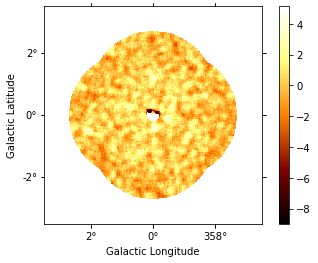

In [144]:
residual2 = estimator.run(stacked_on_off)
residual2['sqrt_ts'].plot(add_cbar=True)

(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x1a8b27198>)

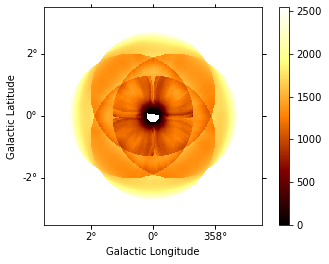

In [145]:
stacked_on_off.acceptance_off.plot(add_cbar=True)

In [146]:
flux_ring = np.nansum(residual2['flux'].quantity 
                   * stacked._geom.pixel_area
                    / corr_rad.value /corr_rad.value/np.pi )
print(flux_ring)

nan 1 / (cm2 s)


/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in reduce
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Fit results: mu = -0.04, std = 0.86


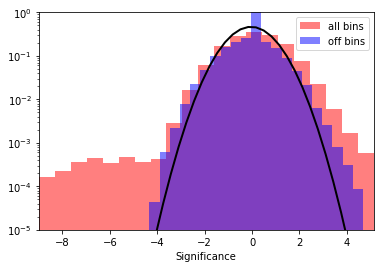

In [147]:
significance_map_off = residual2['sqrt_ts'] * mask
significance_all = residual2['sqrt_ts'].data[np.isfinite(residual2['sqrt_ts'].data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

Now, fit using the ring background - using wstat

In [148]:
#define the sky_model to fit to the data
model_ring = model.copy(name='ring_fit')
model_ring.spectral_model.parameters['index'].frozen = True

In [149]:
L0 = stacked_on_off.stat_sum()

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


In [150]:
# Add the sky model to the dataset
stacked_on_off.models = model_ring

In [151]:
# Now fit
fit = Fit([stacked_on_off])
result = fit.run()
print(result)

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divi

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 28
	total stat : 42051.37



/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


In [152]:
print(result.parameters.to_table())

   name     value      unit      min        max    frozen   error  
--------- ---------- -------- ---------- --------- ------ ---------
amplitude 2.0000e-10 cm-2 s-1        nan       nan  False       nan
    index 2.3000e+00                 nan       nan   True 0.000e+00
     emin 1.0000e+00      TeV        nan       nan   True 0.000e+00
     emax 1.0000e+01      TeV        nan       nan   True 0.000e+00
    lon_0 0.0000e+00      deg        nan       nan  False       nan
    lat_0 0.0000e+00      deg -9.000e+01 9.000e+01  False       nan
    sigma 2.0000e+00      deg  0.000e+00       nan  False       nan
        e 0.0000e+00           0.000e+00 1.000e+00   True 0.000e+00
      phi 0.0000e+00      deg        nan       nan   True 0.000e+00


In [153]:
L1 = stacked_on_off.stat_sum()
print('Detection del(TS) = ', L0-L1)

Detection del(TS) =  0.0


/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


In [154]:
## flux in FoV
geom = stacked.counts._geom
np.sum(model_ring.spatial_model.evaluate_geom(geom)*geom.solid_angle())
flux = model_ring.spatial_model.evaluate_geom(geom)*geom.solid_angle()
flux[stacked.exposure.data == 0.0] = 0.0
correction = np.sum(flux)/geom.axes['energy'].nbin
flux_fov_ring = correction * model_ring.spectral_model.amplitude.quantity
print(flux_fov_ring)

1.1449376219334543e-10 1 / (cm2 s)


Now, fit using the ring background - using cash

In [155]:
stacked_cash=stacked_on_off.to_map_dataset()

In [156]:
stacked_cash.models = model_ring

In [157]:
fit = Fit([stacked_cash])
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 28
	total stat : 67408.57



In [158]:
print(stacked_cash.models.parameters.to_table())

   name     value      unit      min        max    frozen   error  
--------- ---------- -------- ---------- --------- ------ ---------
amplitude 2.0000e-10 cm-2 s-1        nan       nan  False       nan
    index 2.3000e+00                 nan       nan   True 0.000e+00
     emin 1.0000e+00      TeV        nan       nan   True 0.000e+00
     emax 1.0000e+01      TeV        nan       nan   True 0.000e+00
    lon_0 0.0000e+00      deg        nan       nan  False       nan
    lat_0 0.0000e+00      deg -9.000e+01 9.000e+01  False       nan
    sigma 2.0000e+00      deg  0.000e+00       nan  False       nan
        e 0.0000e+00           0.000e+00 1.000e+00   True 0.000e+00
      phi 0.0000e+00      deg        nan       nan   True 0.000e+00


## Now, fit using 3D stacked analysis

- using background models

In [159]:
#This is the background maker
# We fit the background before stacking
maker_fov = FoVBackgroundMaker(method="fit", 
                               exclusion_mask=mask)
bkg_norm_stacked = []
bkg_norm_stacked_err = []

In [160]:
%%time
stacked3D = MapDataset.create(
    geom=datasets[0]._geom, 
    energy_axis_true=datasets[0].exposure.geom.axes['energy_true'], 
    name="stacked3D"
)
for dataset in datasets:
    dataset = maker_fov.run(dataset)
    bkg_norm_stacked.append(dataset.background_model.spectral_model.norm.value)
    bkg_norm_stacked_err.append(dataset.background_model.spectral_model.norm.error)
    stacked3D.stack(dataset)

CPU times: user 5.3 s, sys: 1.45 s, total: 6.75 s
Wall time: 6.81 s


In [161]:
print(stacked3D)

MapDataset
----------

  Name                            : stacked3D 

  Total counts                    : 17597 
  Total background counts         : 16378.09
  Total excess counts             : 1218.91

  Predicted counts                : 16378.10
  Predicted background counts     : 16378.09
  Predicted excess counts         : nan

  Exposure min                    : 6.76e+08 m2 s
  Exposure max                    : 1.10e+10 m2 s

  Number of total bins            : 612500 
  Number of fit bins              : 267420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [162]:
model3D = model.copy(name='model3D')
bkg_model3D = FoVBackgroundModel(dataset_name="stacked3D")

In [163]:
stacked3D.models = bkg_model3D
L2 = stacked3D.stat_sum()

In [164]:
stacked3D.models = [bkg_model3D, model3D]

In [165]:
%%time
fit = Fit([stacked3D])
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 1.177e+05               |     Ncalls=721 (721 total)     |
| EDM = 0.00013 (Goal: 0.0002)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 28.2 s, sys: 3.41 s, total: 31.6 s
Wall time: 31.9 s


In [166]:
print(stacked3D.models.parameters.to_table())

   name      value      unit      min        max    frozen   error  
--------- ----------- -------- ---------- --------- ------ ---------
     norm  8.6648e-01                 nan       nan  False 4.091e-02
     tilt  0.0000e+00                 nan       nan   True 0.000e+00
reference  1.0000e+00      TeV        nan       nan   True 0.000e+00
amplitude  1.2079e-10 cm-2 s-1        nan       nan  False 4.737e-11
    index  2.3045e+00                 nan       nan  False 8.905e-02
     emin  1.0000e+00      TeV        nan       nan   True 0.000e+00
     emax  1.0000e+01      TeV        nan       nan   True 0.000e+00
    lon_0  7.3911e-02      deg        nan       nan  False 1.228e-01
    lat_0 -1.8273e-01      deg -9.000e+01 9.000e+01  False 1.226e-01
    sigma  1.6447e+00      deg  0.000e+00       nan  False 2.483e-01
        e  0.0000e+00           0.000e+00 1.000e+00   True 0.000e+00
      phi  0.0000e+00      deg        nan       nan   True 0.000e+00


In [167]:
L3 = stacked3D.stat_sum()
print('Detection del(TS) = ', L2-L3)

Detection del(TS) =  208.4073691968224


In [168]:
## flux in FoV
geom = stacked.counts._geom
np.sum(model3D.spatial_model.evaluate_geom(geom)*geom.solid_angle())
flux = model3D.spatial_model.evaluate_geom(geom)*geom.solid_angle()
flux[stacked.exposure.data == 0.0] = 0.0
correction = np.sum(flux)/geom.axes['energy'].nbin
flux_fov_stacked = correction * model3D.spectral_model.amplitude.quantity
print(flux_fov_stacked)

8.60620675643087e-11 1 / (cm2 s)


Text(0.5, 1.0, 'bkg norms before stacking')

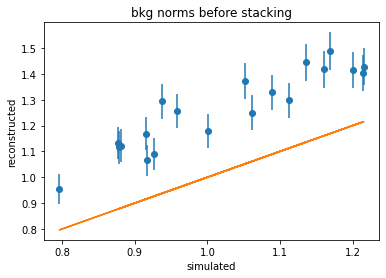

In [169]:
plt.errorbar(simulator.bkg_norms, 
             bkg_norm_stacked, 
             yerr=bkg_norm_stacked_err, fmt='o')
plt.plot(simulator.bkg_norms, simulator.bkg_norms, ls='-')
plt.xlabel('simulated')
plt.ylabel('reconstructed')
plt.title('bkg norms before stacking')

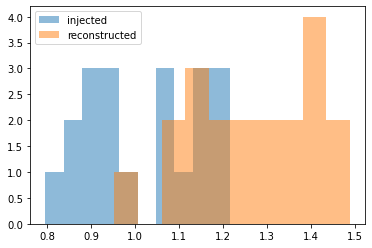

In [170]:
plt.hist(simulator.bkg_norms, alpha=0.5, label='injected')
plt.hist(bkg_norm_stacked, alpha=0.5, label = 'reconstructed')
plt.legend()

In [171]:
len(simulator.bkg_norms)

20

## A joint 3D fitting

- This fits all the datasets together, 
- no stacking, it can be quite time consuming

In [172]:
maker_fov = FoVBackgroundMaker(method="fit", 
                               exclusion_mask=mask)

datasets_fit = Datasets()
for dataset in datasets:
    dataset = maker_fov.run(dataset)
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    bkg_model.spectral_model.norm.min = 0.0
    
    dataset.models = [bkg_model]
    datasets_fit.append(dataset)

In [173]:
%%time

fit_joint = Fit(datasets_fit) #fit only the background
result_joint = fit_joint.run()

CPU times: user 44.2 s, sys: 4.27 s, total: 48.5 s
Wall time: 48.9 s


In [179]:
bkg_norms_before_model = []
for dataset in datasets_fit:
    bkg_norms_before_model.append(dataset.models[0].spectral_model.norm.value)
print(bkg_norms_before_model)

[1.5039023945644532, 1.4262688177947256, 1.417904134056867, 1.1769601001825407, 1.2862817516621297, 1.1943419413209515, 1.1635290004948788, 1.4714290290295304, 1.4876896396509496, 1.1419978812377272, 1.4414501590120126, 1.6365182412537207, 1.3969170419909283, 1.3033353548444842, 1.25195699086182, 1.2402343015188948, 1.391682804990201, 1.3180332468374867, 1.0327526788813346, 1.3379063857907467]


In [174]:
L6 = datasets_fit.stat_sum()
print(L6)

210530.77167091373


In [180]:
model3D_joint = model.copy()
model3D_joint.spectral_model.amplitude.min = 0.0
for dataset in datasets_fit:
    dataset.models = [dataset.models[0], model3D_joint]
    

In [181]:
%%time
fit_joint = Fit(datasets_fit)
result_joint = fit_joint.run()

CPU times: user 11min 38s, sys: 44.4 s, total: 12min 22s
Wall time: 12min 28s


In [182]:
L7 = datasets_fit.stat_sum()
print(L7)

210392.22400887782


In [183]:
print(L6-L7)

138.54766203591134


In [184]:
model3D_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str8,float64,float64,bool,float64
amplitude,1.2362e-10,cm-2 s-1,0.000e+00,nan,False,4.206e-11
index,2.3083e+00,,nan,nan,False,8.287e-02
emin,1.0000e+00,TeV,nan,nan,True,0.000e+00
emax,1.0000e+01,TeV,nan,nan,True,0.000e+00
lon_0,1.4436e-01,deg,nan,nan,False,1.331e-01
lat_0,-1.5199e-01,deg,-9.000e+01,9.000e+01,False,1.303e-01
sigma,1.6470e+00,deg,0.000e+00,nan,False,2.254e-01
e,0.0000e+00,,0.000e+00,1.000e+00,True,0.000e+00
phi,0.0000e+00,deg,nan,nan,True,0.000e+00


In [185]:
## flux in FoV
geom = stacked.counts._geom
np.sum(model3D_joint.spatial_model.evaluate_geom(geom)*geom.solid_angle())
flux = model3D_joint.spatial_model.evaluate_geom(geom)*geom.solid_angle()
flux[stacked.exposure.data == 0.0] = 0.0
correction = np.sum(flux)/geom.axes['energy'].nbin
flux_fov_joint = correction * model3D_joint.spectral_model.amplitude.quantity
print(flux_fov_joint)

8.791314812976289e-11 1 / (cm2 s)


### Compare the injected background systematics vs the recompted ones

In [186]:
bkg_computed = []
bkg_err = []
for dataset in datasets_fit:
    bkg_computed.append(dataset.background_model.spectral_model.norm.value)
    bkg_err.append(dataset.background_model.spectral_model.norm.error)

Text(0, 0.5, 'reconstructed')

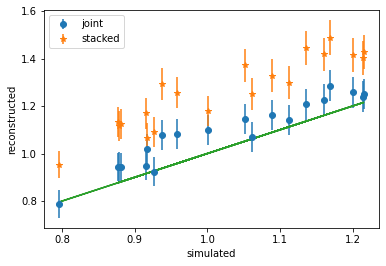

In [187]:
plt.errorbar(simulator.bkg_norms, 
             bkg_computed, 
             yerr=bkg_err, 
             fmt='o',
             label='joint')

plt.errorbar(simulator.bkg_norms, 
             bkg_norm_stacked, 
             yerr=bkg_norm_stacked_err, 
             fmt='*',
             label = 'stacked')
plt.plot(simulator.bkg_norms, simulator.bkg_norms, ls='-')
plt.legend()
plt.xlabel('simulated')
plt.ylabel('reconstructed')

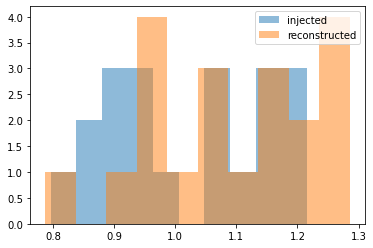

In [188]:

plt.hist(simulator.bkg_norms, alpha=0.5, label='injected')
plt.hist(bkg_computed, alpha=0.5, label = 'reconstructed')
plt.legend()